# IBM Developer Skills Network

In [1]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if ('sc' in locals() or 'sc' in globals()):
    printmd('<<<<<!!!!! It seems that you are running in a IBM Watson Studio Apache Spark Notebook. Please run it in an IBM Watson Studio Default Runtime (without Apache Spark) !!!!!>>>>>')

In [2]:
import findspark
findspark.init()

In [3]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('Please restart kernel!')

In [4]:
sc = SparkContext.getOrCreate(SparkConf().setMaster('local[*]'))

spark = SparkSession.builder.getOrCreate()

In [5]:
# File: https://github.com/sonpn82/Scalable-Machine-Learning-on-Big-Data-using-Apache-Spark/blob/master/washing.parquet?raw=true
# Create a dataFrame from washing.parquet file
df = spark.read.parquet('washing.parquet')
df.count()

2058

In [6]:
# Now we register the data frame in the ApacheSparkSQL catalog so that we can query it using SQL
# Creates or replaces a local temporary view with this DataFrame
df.createOrReplaceTempView('washing')
spark.sql('Select * from washing').show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [7]:
# Get a sample from original dataframe to reduce load on the plotting work
result = spark.sql('select voltage from washing where voltage is not null')

# map function apply a lambda function on every row of the dataframe (need converted to rdd 1st)
# in this case, get voltage col value out of every row and take 10% sample
result_array = result.rdd.map(lambda row : row.voltage).sample(False, 0.1).collect()

# Print the 1st 15 elements
result_array[:15]  # result array is a python list item

[226, 224, 232, 231, 222, 228, 220, 239, 232, 238, 228, 238, 239, 238, 224]

# Box Plot

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

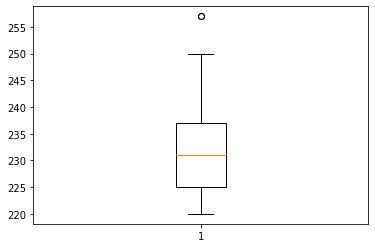

In [10]:
plt.boxplot(result_array)
plt.show()

# Line plot

In [12]:
result = spark.sql('select voltage, ts from washing where voltage is not null order by ts asc')
result_rdd = result.rdd.sample(False, 0.1).map(lambda row : (row.ts, row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()

print(result_array_ts[:15])
print(result_array_voltage[:15])

[1547808737926, 1547808788955, 1547808846029, 1547808855034, 1547808876043, 1547808981157, 1547809005175, 1547809041212, 1547809050217, 1547809083238, 1547809089240, 1547809095246, 1547809143268, 1547809164281, 1547809209328]
[234, 236, 233, 221, 221, 228, 252, 235, 234, 224, 227, 237, 223, 220, 227]


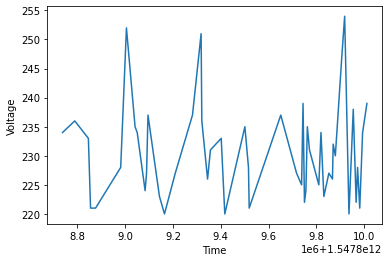

In [13]:
plt.plot(result_array_ts, result_array_voltage)
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()

## Plot data worth of 1 hour only

In [14]:
spark.sql('select min(ts), max(ts) from washing').show()

+-------------+-------------+
|      min(ts)|      max(ts)|
+-------------+-------------+
|1547808720911|1547810064867|
+-------------+-------------+



In [15]:
result = spark.sql(
"""
select voltage,ts from washing 
    where voltage is not null and 
    ts > 1547808720911 and
    ts <= 1547810064867+3600000
    order by ts asc
""")

result_rdd = result.rdd.map(lambda row: (row.ts, row.voltage))

In [16]:
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()

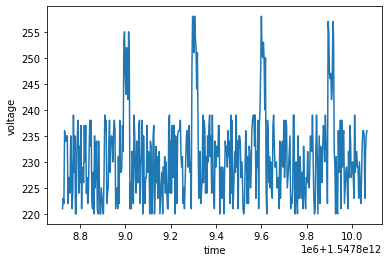

In [17]:
plt.plot(result_array_ts, result_array_voltage)
plt.xlabel('time')
plt.ylabel('voltage')
plt.show()

# 3D scatter plot

In [18]:
result_df = spark.sql("""
select hardness,temperature,flowrate from washing
    where hardness is not null and 
    temperature is not null and 
    flowrate is not null
""")
result_rdd = result_df.rdd.sample(False,0.1).map(lambda row : (row.hardness,row.temperature,row.flowrate))
result_array_hardness = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[0]).collect()
result_array_temperature = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[1]).collect()
result_array_flowrate = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[2]).collect()

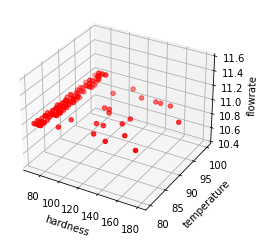

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_array_hardness, result_array_temperature, result_array_flowrate, c='r', marker='o')

ax.set_xlabel('hardness')
ax.set_ylabel('temperature')
ax.set_zlabel('flowrate')

plt.show()

# Histogram

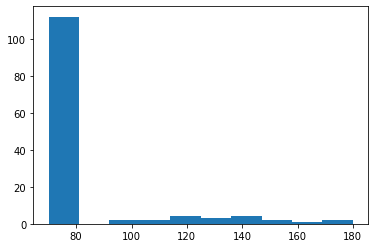

In [22]:
plt.hist(result_array_hardness)
plt.show()

In [ ]:
# Most of data stay near 80 value of hardness